In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from models.partially_freezed_resnet import get_resnet
from utils.losses import ContrastiveLossWithMargin, EuclideanLoss
from datasets.base_unsupervised_deepfake import DatasetBaseUnsupervised_deepfake
from datasets.base_unsupervised_deepfake_idempotence import DatasetBaseUnsupervised_deepfake_idempotence
from datasets.unsupervised_dataset_deepfake import MultiCropDatasetDeepfake
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned only with teacher/finetuned-backbone.pth"))
my_model.to(device)

CustomModel(
  (existing_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [4]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake('data_deepfake/compact-test/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[0.8],[1.0])

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)

Base unsupervised dataloader initialised successfully
5415


## Evaluating the learning from teacher and increasing the distance

In [8]:
# evaluate model:
my_model.eval()


distances = []
losses_teacher_raw = []
losses_teacher_recons = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_raw_features, batch_recons_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features)
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons)
        distances.append(euclidean_distance.item())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

import numpy as np
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))

11669.356787109375 1514.9482421875 25896.1875
15317.385759420957 10277.041015625 22902.822265625
13472.327240349265 9170.47265625 19629.060546875


## Evaluating the model on gen and gen-gen data

In [9]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-idempotence/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features)
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double)
        _, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        _, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        distances.append(euclidean_distance.item())
        distances_idempotence.append(euclidean_idempotence.item())
        efficientnet_distances.append(effi_euclidean.item())
        efficientnet_distances_idempotence.append(effi_euclidean_idempotence.item())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())


import numpy as np
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))

8.570490817462696 6.488631248474121 12.180471420288086
2.4400228465304656 1.8118476867675781 3.313544750213623
34.162043795866126 24.346328735351562 45.395259857177734
8.389133918986602 4.903677940368652 11.299165725708008
38.53285890467026 35.18788146972656 42.60418701171875
36.721297028485466 33.80253601074219 41.68567657470703


## Evaluating the model on real deepfake (swapped data)
## using finetuned with only teacher

Base unsupervised dataloader initialised successfully
3859
8.840829429253608 0.1290731132030487 54.979637145996094
6.366446273449647 0.029476935043931007 37.6978874206543
only teacher tuned  AUC= 0.6499616804619913
35.897809194592526 0.06309010088443756 113.6646728515625
25.745265996117887 0.06982073187828064 105.45792388916016
39.32777338579667 36.19880676269531 42.877601623535156
36.32567249644887 32.74309158325195 39.57489013671875
Efficientnet  AUC= 0.6534829951971817


Text(0.5, 1.0, 'Probability Density Plot for Data')

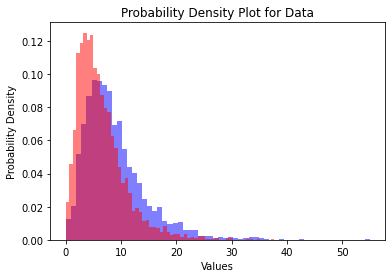

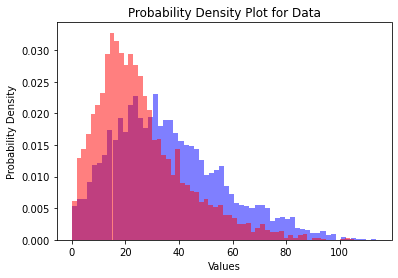

In [31]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned only with teacher/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)


# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features)
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())


import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('only teacher tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')

## Evaluating the model on real deepfake (swapped data)
## using finetuned with test data (initialized with only teacher)

19.114920259869663 0.16217675805091858 88.1906967163086
11.474222705333876 0.04974912106990814 67.3466567993164
test tuned  AUC= 0.6736010044667964
35.897809194592526 0.06309010088443756 113.6646728515625
25.745265996117887 0.06982073187828064 105.45792388916016
8.744761774362612 8.046015739440918 9.455134391784668
9.140204910404426 8.247145652770996 9.81661605834961
Efficientnet  AUC= 0.6534829951971817


Text(0.5, 1.0, 'Probability Density Plot for Data')

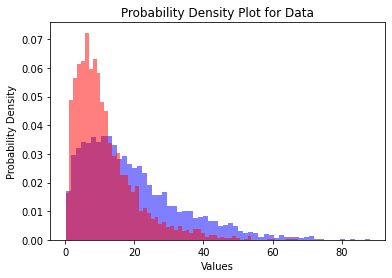

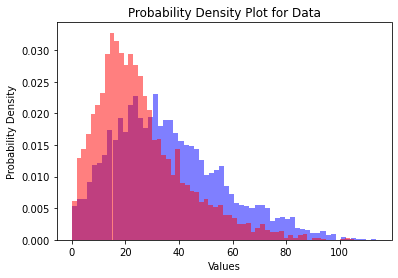

In [30]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned on compact-test-swapped/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features)
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())


import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('test tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')

## EXP 1
## Evaluating the model on real deepfake (swapped data)
## using finetuned using test data (D11,D22) distance (cropped controlled) (initialized with only teacher)

Base unsupervised dataloader initialised successfully
3859
Base unsupervised dataloader initialised successfully
5415
327008.21662850206 1.484926462173462 1457049.625
160188.78522854298 0.5248475670814514 2508299.75
test tuned  AUC= 0.751205262511853
34.112833637109205 0.13639600574970245 113.99568176269531
25.745265996117887 0.06982073187828064 105.45792388916016
225514.39218213057 127871.984375 1148862.5
124189.0391967354 45357.4296875 996678.5625
Efficientnet  AUC= 0.6438217480116871


Text(0.5, 1.0, 'Probability Density Plot for Data')

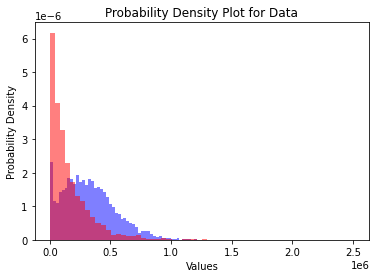

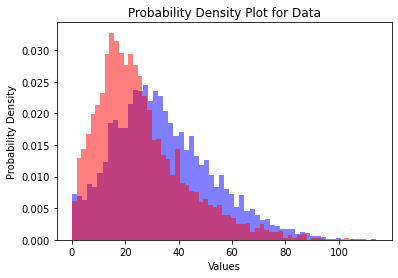

In [3]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
# swapped approach dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

# generator approach dataset
deepfake_compact_dataset2 = DatasetBaseUnsupervised_deepfake('data_deepfake/compact-test/')
resized_augmented_dataset2 = MultiCropDatasetDeepfake(deepfake_compact_dataset2,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned on distances crop controlled/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)
dataloader2 = DataLoader(resized_augmented_dataset2, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D22 (swapped)
        #loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_raw_gen) # dis(D1,D2)
        #euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_raw_gen, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double) #dis(D22, D3)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        #effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_raw_gen_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        #distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        #efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

for i, (batch_raw_im, batch_recons_im, batch_raw_features, batch_recons_features) in enumerate(dataloader2):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D2 (swapped)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons) # dis(D1,D2)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)

        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('test tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')

## EXP 3
## Evaluating the model on real deepfake (swapped data) and D1-D2
## using finetuned using train data (D1,D2) distance (cropped controlled) (initialized with FLR)

Base unsupervised dataloader initialised successfully
3859
Base unsupervised dataloader initialised successfully
5415
2886681.4417951717 0.4732377529144287 90190432.0
1560346.1558542487 17.022769927978516 55548032.0
celebdf tuned  AUC= 0.579319009871756
34.112833637109205 0.13639600574970245 113.99568176269531
25.745265996117887 0.06982073187828064 105.45792388916016
13495187.64089347 6277160.0 23081992.0
6849507.223367698 2710404.5 13255580.0
Efficientnet  AUC= 0.6438217480116871


Text(0.5, 1.0, 'Probability Density Plot for Data')

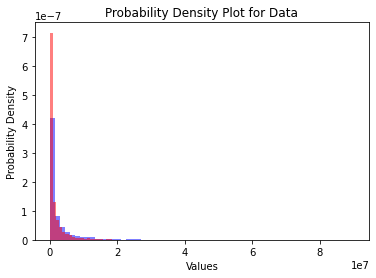

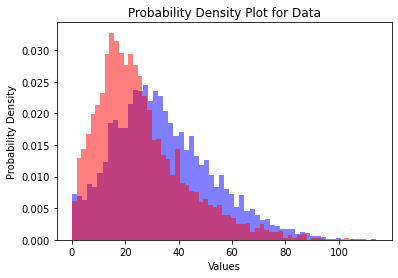

In [4]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
# swapped approach dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

# generator approach dataset
deepfake_compact_dataset2 = DatasetBaseUnsupervised_deepfake('data_deepfake/compact-test/')
resized_augmented_dataset2 = MultiCropDatasetDeepfake(deepfake_compact_dataset2,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned only distance/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)
dataloader2 = DataLoader(resized_augmented_dataset2, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D22 (swapped)
        #loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_raw_gen) # dis(D1,D2)
        #euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_raw_gen, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double) #dis(D22, D3)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        #effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_raw_gen_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        #distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        #efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

for i, (batch_raw_im, batch_recons_im, batch_raw_features, batch_recons_features) in enumerate(dataloader2):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D2 (swapped)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons) # dis(D1,D2)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)

        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('celebdf tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')

Base unsupervised dataloader initialised successfully
3859
Base unsupervised dataloader initialised successfully
5415
988939.4998891585 27.429349899291992 9476826.0
570927.7341508496 5.305327892303467 7458894.5
celebdf tuned  AUC= 0.6803140097485295
34.112833637109205 0.13639600574970245 113.99568176269531
25.745265996117887 0.06982073187828064 105.45792388916016
3627318.0068728523 2285751.5 5543822.5
1207051.8956185568 576942.1875 2370555.5
Efficientnet  AUC= 0.6438217480116871


Text(0.5, 1.0, 'Probability Density Plot for Data')

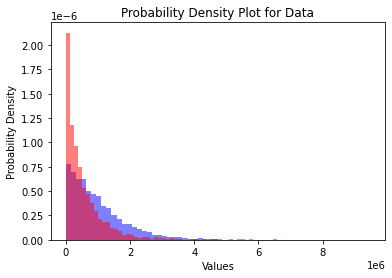

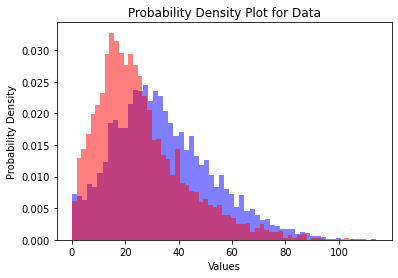

In [3]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
# swapped approach dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

# generator approach dataset
deepfake_compact_dataset2 = DatasetBaseUnsupervised_deepfake('data_deepfake/compact-test/')
resized_augmented_dataset2 = MultiCropDatasetDeepfake(deepfake_compact_dataset2,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned on compact-train-swapped/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)
dataloader2 = DataLoader(resized_augmented_dataset2, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D22 (swapped)
        #loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_raw_gen) # dis(D1,D2)
        #euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_raw_gen, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double) #dis(D22, D3)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        #effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_raw_gen_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        #distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        #efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

for i, (batch_raw_im, batch_recons_im, batch_raw_features, batch_recons_features) in enumerate(dataloader2):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D2 (swapped)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons) # dis(D1,D2)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)

        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('celebdf tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')

Base unsupervised dataloader initialised successfully
3859
Base unsupervised dataloader initialised successfully
5415
8.55468585286857 0.07997342199087143 54.35848617553711
6.37312795289525 0.029476935043931007 36.76567459106445
celebdf tuned  AUC= 0.6314503850767247
34.112833637109205 0.13639600574970245 113.99568176269531
25.745265996117887 0.06982073187828064 105.45792388916016
38.85558412165167 34.91674041748047 42.79670715332031
36.54094744547945 32.72869110107422 42.05327224731445
Efficientnet  AUC= 0.6438217480116871


Text(0.5, 1.0, 'Probability Density Plot for Data')

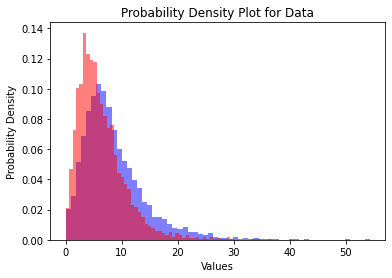

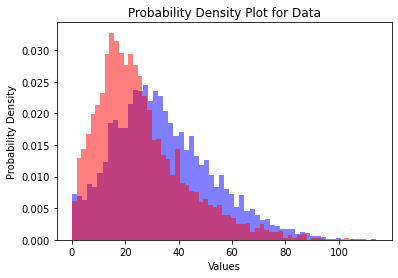

In [4]:
# Step 1: Prepare the dataset
# Create an instance of your custom dataset
# swapped approach dataset
deepfake_compact_dataset = DatasetBaseUnsupervised_deepfake_idempotence('data_deepfake/compact-test-swapped/')
resized_augmented_dataset = MultiCropDatasetDeepfake(deepfake_compact_dataset,[224],[1],[1.0],[1.0],augment=True)

# generator approach dataset
deepfake_compact_dataset2 = DatasetBaseUnsupervised_deepfake('data_deepfake/compact-test/')
resized_augmented_dataset2 = MultiCropDatasetDeepfake(deepfake_compact_dataset2,[224],[1],[1.0],[1.0],augment=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

my_model = get_resnet(device)
my_model.load_state_dict(torch.load("finetuned only with teacher/finetuned-backbone.pth"))
my_model.to(device)

# Step 3: Specify loss function and optimizer
criterion = EuclideanLoss()  # Mean squared error loss
criterion_contrast = ContrastiveLossWithMargin(50)
# optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic Gradient Descent

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(resized_augmented_dataset, batch_size=batch_size, shuffle=False)
dataloader2 = DataLoader(resized_augmented_dataset2, batch_size=batch_size, shuffle=False)

# evaluate model:
my_model.eval()


distances = []
distances_idempotence = []
losses_teacher_raw = []
losses_teacher_recons = []
efficientnet_distances = []
efficientnet_distances_idempotence = []
# Iterate over the DataLoader
for i, (batch_raw_im, batch_recons_im, batch_double_im, batch_raw_features, batch_recons_features, batch_double_features) in enumerate(dataloader):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        batch_double_features = torch.squeeze(batch_double_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        out_feature_double = my_model(batch_double_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D22 (swapped)
        #loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_raw_gen) # dis(D1,D2)
        #euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_raw_gen, keepdim = True),2)
        loss_idempotence, euclidean_idempotence = criterion_contrast(out_feature_recons, out_feature_double) #dis(D22, D3)
        euclidean_idempotence_per_image = torch.pow(F.pairwise_distance(out_feature_recons, out_feature_double, keepdim = True),2)
        #_, effi_euclidean = criterion_contrast(batch_raw_features, batch_recons_features)
        #effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_raw_gen_features, keepdim = True),2)
        #_, effi_euclidean_idempotence = criterion_contrast(batch_recons_features, batch_double_features)
        effi_idempotence_distance_per_image = torch.pow(F.pairwise_distance(batch_recons_features, batch_double_features, keepdim = True),2)
        #distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        distances_idempotence.extend(euclidean_idempotence_per_image.cpu().numpy()[:,0].tolist())
        #efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances_idempotence.extend(effi_idempotence_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

for i, (batch_raw_im, batch_recons_im, batch_raw_features, batch_recons_features) in enumerate(dataloader2):
    # Process the batch_data and batch_labels here
    #print(f"number of crops: {len(batch_raw_im)}")
    #print(f"Batch data shape: {batch_raw_im[0].shape}, Batch labels shape: {torch.squeeze(batch_raw_features).shape}")
    with torch.no_grad():
        batch_raw_features = torch.squeeze(batch_raw_features)
        batch_recons_features = torch.squeeze(batch_recons_features)
        out_feature_raw = my_model(batch_raw_im[0].to(device)) # single crops
        out_feature_recons = my_model(batch_recons_im[0].to(device)) # # single crops
        loss_raw_teacher_net = criterion(out_feature_raw, batch_raw_features) #D1
        loss_recons_teacher_net = criterion(out_feature_recons, batch_recons_features) #D2 (swapped)
        loss_contrastive, euclidean_distance = criterion_contrast(out_feature_raw, out_feature_recons) # dis(D1,D2)
        euclidean_distance_per_image = torch.pow(F.pairwise_distance(out_feature_raw, out_feature_recons, keepdim = True),2)

        effi_euclidean_distance_per_image = torch.pow(F.pairwise_distance(batch_raw_features, batch_recons_features, keepdim = True),2)
        distances.extend(euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        efficientnet_distances.extend(effi_euclidean_distance_per_image.cpu().numpy()[:,0].tolist())
        losses_teacher_raw.append(loss_raw_teacher_net.item())
        losses_teacher_recons.append(loss_recons_teacher_net.item())

import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(np.mean(distances), np.min(distances), np.max(distances))
print(np.mean(distances_idempotence), np.min(distances_idempotence), np.max(distances_idempotence))
prediction = np.concatenate((distances, distances_idempotence))
actual = np.concatenate((np.ones(len(distances)), np.zeros(len(distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('celebdf tuned  AUC=', roc_auc)
# Create a histogram to visualize the probability density of the data
plt.figure()
plt.hist(distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')


print(np.mean(efficientnet_distances), np.min(efficientnet_distances), np.max(efficientnet_distances))
print(np.mean(efficientnet_distances_idempotence), np.min(efficientnet_distances_idempotence), np.max(efficientnet_distances_idempotence))
print(np.mean(losses_teacher_raw), np.min(losses_teacher_raw), np.max(losses_teacher_raw))
print(np.mean(losses_teacher_recons), np.min(losses_teacher_recons), np.max(losses_teacher_recons))
prediction = np.concatenate((efficientnet_distances, efficientnet_distances_idempotence))
actual = np.concatenate((np.ones(len(efficientnet_distances)), np.zeros(len(efficientnet_distances_idempotence))))
false_pos_rate, true_pos_rate, _ = roc_curve(actual, prediction)
roc_auc = auc(false_pos_rate, true_pos_rate)
print('Efficientnet  AUC=', roc_auc)
plt.figure()
plt.hist(efficientnet_distances, bins=60, density=True, alpha=0.5, color='b', label='Auth')
plt.hist(efficientnet_distances_idempotence, bins=60, density=True, alpha=0.5, color='r', label='Deepfake')
# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot for Data')